In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(800, 600))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [4]:
# HIDE OUTPUT
env = wrap_env(gym.make("Pendulum-v0"))

observation = env.reset()

while True:

    env.render()

    # your agent goes here
    action = env.action_space.sample()

    observation, reward, done, info = env.step(action)

    if done:
        break

env.close()
show_video()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

import random
from collections import deque

In [6]:
class PolicyNetwork(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(state_space_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
        )

        self.mean = nn.Linear(64, action_space_dim)
        self.log_sd = nn.Linear(64, action_space_dim)

    def forward(self, x):
        h = self.network(x)
        return self.mean(h), torch.clip(self.log_sd(h), -5, 5)


In [7]:
class ValueNetwork(nn.Module):

    def __init__(self, state_space_dim):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(state_space_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)


In [8]:
class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, log_prob, reward, next_state, done):
        experience = (state, action, log_prob, np.array([reward]), next_state, np.array([done]))
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        log_prob_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, log_prob, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            log_prob_batch.append(log_prob)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, log_prob_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)


In [9]:
def log_prob_normal(x, mean, log_sd):
    return -0.5 * ((x - mean) * torch.exp(-log_sd)) ** 2 - log_sd - 0.5 * np.log(2 * np.pi)


In [10]:
class PPOAgent:
    def __init__(self, state_space_dim, action_space_dim):
        self.gamma = 0.99
        self.clip_param = 0.1
        self.state_space_dim = state_space_dim
        self.action_space_dim = action_space_dim

        self.memory = Memory(1000)

        self.policy_net = PolicyNetwork(state_space_dim, action_space_dim)
        self.policy_opt = torch.optim.Adam(self.policy_net.parameters(), lr=1e-4)

        self.value_net = ValueNetwork(state_space_dim)
        self.value_opt = torch.optim.Adam(self.value_net.parameters(), lr=1e-3)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            mean, log_sd = self.policy_net(state)
            sd = torch.exp(log_sd)
            action = mean + sd * torch.randn_like(mean)

        return action.detach().cpu().numpy(), log_prob_normal(action, mean, log_sd).cpu().numpy()

    def update_policy(self, state_batch, action_batch, log_prob_batch, reward_batch, next_state_batch):
        state_batch = torch.tensor(state_batch, dtype=torch.float32)
        action_batch = torch.tensor(action_batch, dtype=torch.float32)
        log_prob_batch = torch.tensor(log_prob_batch, dtype=torch.float32)
        reward_batch = torch.tensor(reward_batch, dtype=torch.float32)
        next_state_batch = torch.tensor(next_state_batch, dtype=torch.float32)

        with torch.no_grad():
            state1_value = self.value_net(state_batch)
            state2_value = self.value_net(next_state_batch)
            value_target = reward_batch + self.gamma * state2_value

        advantage = value_target - state1_value

        mean, log_sd = self.policy_net(state_batch)
        log_prob = log_prob_normal(action_batch, mean, log_sd)

        ratio = torch.exp(log_prob - log_prob_batch)

        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                            1.0 + self.clip_param) * advantage
        action_loss = -torch.minimum(surr1, surr2).mean()

        self.policy_opt.zero_grad()
        action_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 100)

        self.policy_opt.step()

        value_loss = (self.value_net(state_batch) - value_target) ** 2
        value_loss = value_loss.mean()
        self.value_opt.zero_grad()

        value_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), 100)
        self.value_opt.step()

        #print(f"action_loss {action_loss}")
        #print(f"value_loss {value_loss}")

    def update(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        state_batch, action_batch, log_prob_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            batch_size)

        self.update_policy(state_batch, action_batch, log_prob_batch, reward_batch, next_state_batch)


In [11]:
env = gym.make("Pendulum-v0")
total_episodes = 500

agent = PPOAgent(3, 1)

rewards = []
smooth_rewards = []

total_steps = 0

for episode in tqdm(range(1, total_episodes + 1)):
    state = env.reset()

    episode_reward = 0
    max_steps = 200
    for step in range(max_steps):
        action, log_like = agent.choose_action(state)

        next_state, reward, done, info = env.step(action)

        episode_reward += reward

        agent.memory.push(state, action, log_like, reward, next_state, done)

        total_steps += 1
        
        agent.update()

        if done:
            break

        state = next_state

    rewards.append(episode_reward)
    smooth_rewards.append(np.mean(rewards[-10:]))

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


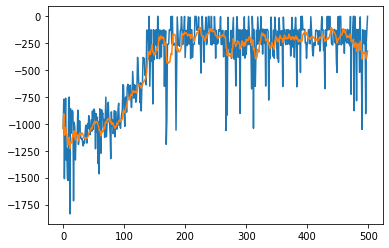

In [12]:
plt.plot(rewards)
plt.plot(smooth_rewards)
plt.show()

In [15]:
env = wrap_env(gym.make("Pendulum-v0"))

observation = env.reset()

while True:

    env.render()
    
    action, _ = agent.choose_action(observation)

    observation, reward, done, info = env.step(action)

    if done:
        break

env.close()
show_video()